# Evaluating performance

Analysis by [Laurent Lessard](https://laurentlessard.com/) and [Vincent Tjeng](https://vtjeng.com).

This file applies the strategy from `wordle_solver.ipynb` to all possible words and creates histograms to show the results. 

For efficiency, `performance.ipynb` pre-computes and cache all possible measurements of word pairs (via `cache_word_scores`) and works with the indices of the words in the `ALL_WORDS` list, rather than the words themselves. This improves efficiency significantly as we run the strategy repeatedly on all words in the dictionary.

In [1]:
# for prop, freqtable
using FreqTables
include("utils.jl");

In [2]:
cache_word_scores(ALL_WORDS, SOLUTION_WORDS)

 11.815986 seconds (172.37 M allocations: 14.203 GiB, 7.99% gc time, 0.03% compilation time)


## Helper Functions

In [13]:
function get_display_text(heuristic::Heuristic)::String
    if heuristic == PRIORITIZE_MAX_GROUP_SIZE
        return "size"
    elseif heuristic == PRIORITIZE_ENTROPY
        return "entropy"
    elseif heuristic == PRIORITIZE_SPLITS
        return "splits"
    end
    throw(ArgumentError("Unexpected heuristic."))
end


function word_stats(
    starting_word::Int;
    guess_all_words::Bool = false,
    heuristic::Heuristic = PRIORITIZE_ENTROPY,
    hard_mode::Bool = false,
)
    num_turns = get_num_turns(
        guess_all_words ? ALL_WORD_IDXS : SOLUTION_WORD_IDXS,
        SOLUTION_WORD_IDXS,
        heuristic = heuristic,
        hard_mode = hard_mode,
        starting_word = starting_word
    )
    return [prop(freqtable(num_turns)), Statistics.mean(num_turns), maximum(num_turns)]
end

function generate_stats(;
    guess_all_words::Bool = false,
    hard_mode::Bool = false,
    heuristic::Heuristic = PRIORITIZE_ENTROPY,
    max_val::Int = 0
)
    num_turns = get_num_turns(
        guess_all_words ? ALL_WORD_IDXS : SOLUTION_WORD_IDXS,
        SOLUTION_WORD_IDXS,
        heuristic = heuristic,
        hard_mode = hard_mode,
        verbose = true
    )

    heuristic_text = get_display_text(heuristic)
    fn_1 = hard_mode ? "hard_mode_" : ""
    fn_2 = guess_all_words ? "any_guess_" : "solutions_only_"
    tt_1 = hard_mode ? "hard mode, " : ""
    tt_2 = guess_all_words ? "any guess allowed " : "only guess from solutions list "
    plot_num_turns(
        num_turns,
        title_text = "$(tt_1)$(tt_2)(max-$(heuristic_text))",
        saved_filename = "strat_using_$(fn_1)$(fn_2)prioritize_$(heuristic_text).png",
        max_val = max_val
    )

    println("\nProportions")
    println(prop(freqtable(num_turns)))

    println("\nMean Score")
    println(Statistics.mean(num_turns))
end

generate_stats (generic function with 1 method)

## Comparison of different starting words (simple strategy)

In [32]:
@time begin
solnstats = [ word_stats( i, heuristic=PRIORITIZE_SPLITS, hard_mode=false, guess_all_words=false ) for i in SOLUTION_WORD_IDXS ]
end;

3925.331495 seconds (86.97 G allocations: 4.186 TiB, 9.20% gc time, 0.00% compilation time)


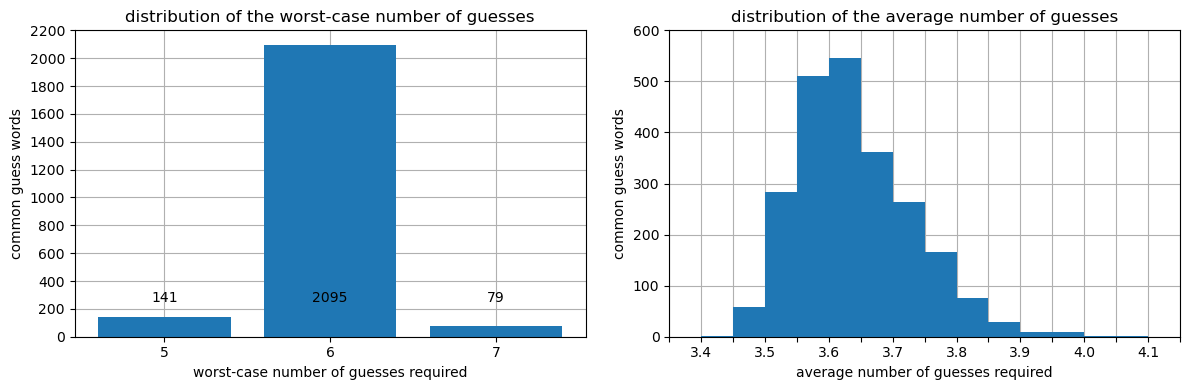

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
["model", "death", "react", "sower", "unmet", "forth", "wooer", "biome", "labor", "world"]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
["tenth", "theft", "mamma", "chess", "magma", "setup", "gummy", "scree", "sully", "snore", "feral"]
[3.449244060475162, 3.4548596112311016, 3.455291576673866, 3.455291576673866, 3.4634989200863933]
["slate", "trace", "crate", "crane", "slant", "least", "stale", "trice", "roast", "stare"]


In [148]:
figure(figsize=(12,4))
subplot(1,2,1)
mxs = [solnstats[i][3] for i in SOLUTION_WORD_IDXS]
maxes = countmap(mxs)
k = collect(keys(maxes))
v = collect(values(maxes))
bar( k,v, zorder=2  )
xticks(k)
yticks(0:200:2200)
xlabel("worst-case number of guesses required")
ylabel("common guess words")
title("distribution of the worst-case number of guesses")
grid(zorder=1)
for i in 1:length(k)
    text(k[i],250, v[i], horizontalalignment = "center")
end

ix = sortperm(mxs)
mm = 10
println(mxs[ix[1:mm]])
println(SOLUTION_WORDS[ix[1:mm]])
println(mxs[ix[end-mm:end]])
println(SOLUTION_WORDS[ix[end-mm:end]])

subplot(1,2,2)
avgs = [solnstats[i][2] for i in SOLUTION_WORD_IDXS]
hist( avgs, bins=3.35:0.05:4.15, zorder=2 );
grid(zorder=1)
xlabel("average number of guesses required")
ylabel("common guess words")
title("distribution of the average number of guesses")
xticks(3.35:0.05:4.15, ["",3.4,"",3.5,"",3.6,"",3.7,"",3.8,"",3.9,"",4.0,"",4.1,""])
xlim([3.35,4.15])
ylim([0,600])

ix = sortperm(avgs)
println(avgs[ix[1:5]])
println(SOLUTION_WORDS[ix[1:10]])

tight_layout(w_pad=2)
savefig("figures/common_word_strat_comparison.png", dpi=400);

In [142]:
@time begin
solnstats_hard = [ word_stats( i, heuristic=PRIORITIZE_SPLITS, hard_mode=true, guess_all_words=false ) for i in SOLUTION_WORD_IDXS ]
end;

220.645934 seconds (4.89 G allocations: 163.597 GiB, 7.39% gc time, 0.01% compilation time)


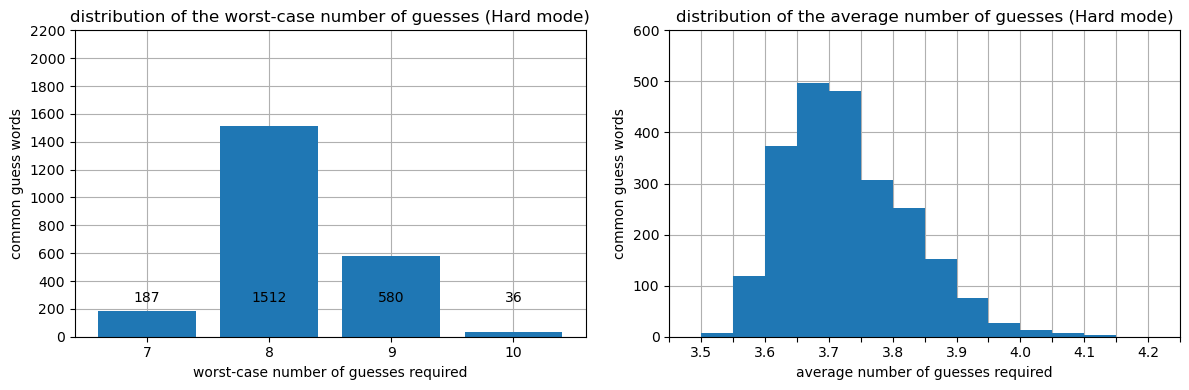

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
["humph", "focal", "crust", "whelp", "trawl", "belly", "salad", "spray", "spend", "thumb"]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
["token", "ankle", "ladle", "ditch", "angel", "coven", "liken", "yacht", "clone", "bigot", "judge"]
[3.5287257019438445, 3.5317494600431965, 3.535637149028078, 3.540388768898488, 3.5451403887688984]
["slate", "trace", "least", "crate", "crane", "slant", "stale", "train", "trice", "leant"]


In [147]:
figure(figsize=(12,4))
subplot(1,2,1)
mxs = [solnstats_hard[i][3] for i in SOLUTION_WORD_IDXS]
maxes = countmap(mxs)
k = collect(keys(maxes))
v = collect(values(maxes))
bar( k,v, zorder=2  )
xticks(k)
yticks(0:200:2200)
xlabel("worst-case number of guesses required")
ylabel("common guess words")
title("distribution of the worst-case number of guesses (Hard mode)")
grid(zorder=1)
for i in 1:length(k)
    text(k[i],250, v[i], horizontalalignment = "center")
end

ix = sortperm(mxs)
mm = 10
println(mxs[ix[1:mm]])
println(SOLUTION_WORDS[ix[1:mm]])
println(mxs[ix[end-mm:end]])
println(SOLUTION_WORDS[ix[end-mm:end]])

subplot(1,2,2)
avgs = [solnstats_hard[i][2] for i in SOLUTION_WORD_IDXS]
hist( avgs, bins=3.35:0.05:4.15, zorder=2 );
grid(zorder=1)
xlabel("average number of guesses required")
ylabel("common guess words")
title("distribution of the average number of guesses (Hard mode)")
xticks(3.45:0.05:4.25, ["",3.5,"",3.6,"",3.7,"",3.8,"",3.9,"",4.0,"",4.1,"",4.2,""])
xlim([3.45,4.25])
ylim([0,600])

ix = sortperm(avgs)
println(avgs[ix[1:5]])
println(SOLUTION_WORDS[ix[1:10]])

tight_layout(w_pad=2)
savefig("figures/common_word_strat_comparison_hard.png", dpi=400)

---

## Additional plots for blog post

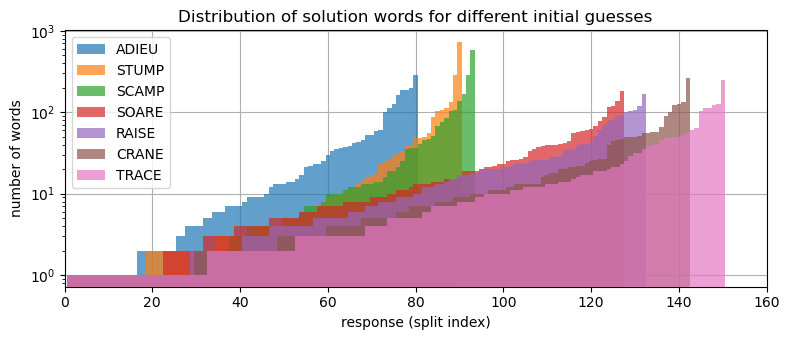

In [327]:
figure(figsize=(8,3.5))
wlist = ["adieu", "stump", "scamp", "soare", "raise", "crane", "trace"]
for w in wlist
    g = sort!(get_group_sizes(w,SOLUTION_WORDS))
    bar(1:length(g), g, label=uppercase(w), width=1, alpha=0.7, zorder=4, log=true)
end
xlim([0,160])
xlabel("response (split index)")
ylabel("number of words")
grid(zorder=2)
legend()
title("Distribution of solution words for different initial guesses")
tight_layout()
savefig("figures/word_pdf.png", dpi=600)

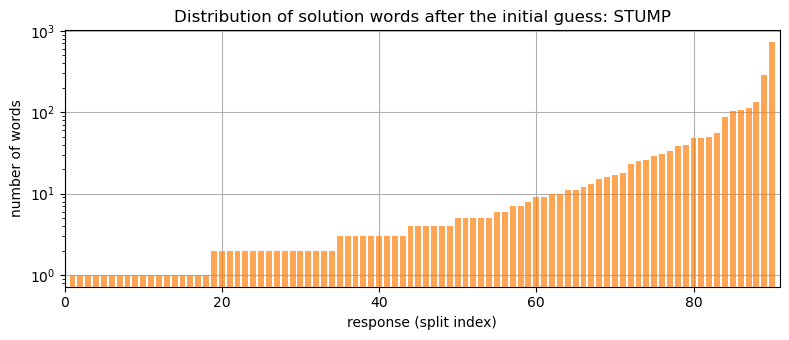

In [328]:
figure(figsize=(8,3.5))
wlist = ["stump"]
for w in wlist
    g = sort!(get_group_sizes(w,SOLUTION_WORDS))
    bar(1:length(g), g, color="C1", label=uppercase(w), width=0.75, alpha=0.7, zorder=4, log=true)
end
xlim([0,91])
xlabel("response (split index)")
ylabel("number of words")
grid(zorder=2)
title("Distribution of solution words after the initial guess: STUMP")
# legend(loc="upper right")
tight_layout()
savefig("figures/word_pdf_stump.png", dpi=600)

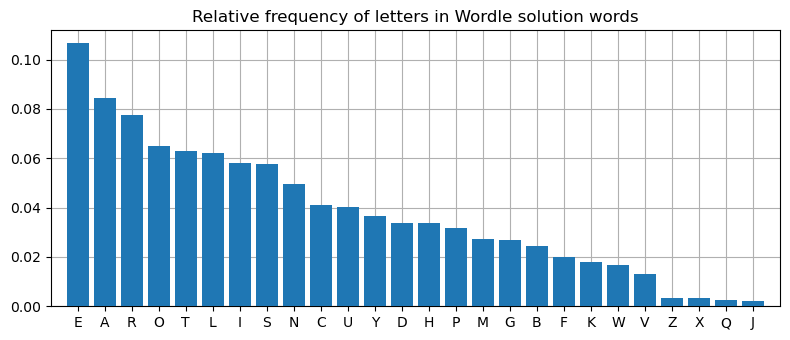

In [324]:
x = countmap(split(uppercase(join(SOLUTION_WORDS)),""))
k = collect(keys(x))
v = collect(values(x)) / length(join(SOLUTION_WORDS))
I = sortperm(v, rev=true)

figure(figsize=(8,3.5))
bar(1:26,v[I],tick_label=k[I],zorder=4)
grid(zorder=2)
xlim([0,27])
title("Relative frequency of letters in Wordle solution words")
tight_layout()
savefig("figures/lett_freq.png", dpi=600)

---

## Results

### Using only solution words as guesses, prioritizing entropy

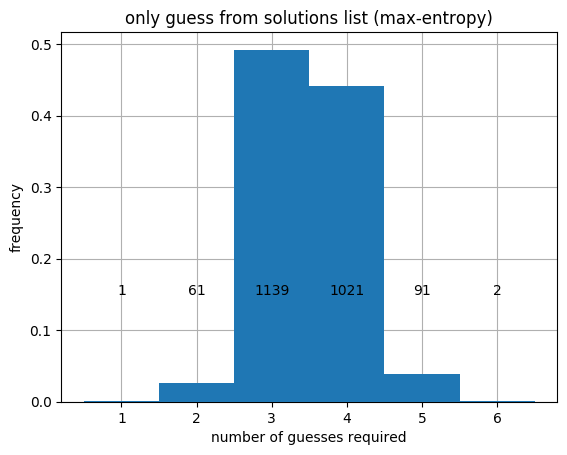

Guess: raise

Proportions
6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0263499
3     │    0.492009
4     │    0.441037
5     │   0.0393089
6     │ 0.000863931

Mean Score
3.4950323974082074
  4.962752 seconds (55.00 M allocations: 2.566 GiB, 9.96% gc time, 50.64% compilation time)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/vtjeng/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [4]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = false,
    heuristic = PRIORITIZE_ENTROPY
)

### Using only solution words as guesses, prioritizing maxsize

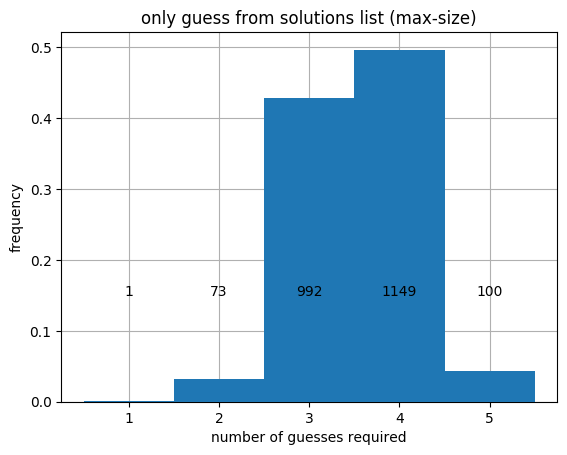

Guess: raise

Proportions
5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0315335
3     │     0.42851
4     │    0.496328
5     │   0.0431965

Mean Score
3.5503239740820733
  2.527476 seconds (51.92 M allocations: 2.396 GiB, 25.09% gc time, 0.13% compilation time)


In [5]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = false,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE
)

### Using only solution words as guesses, prioritizing max splits

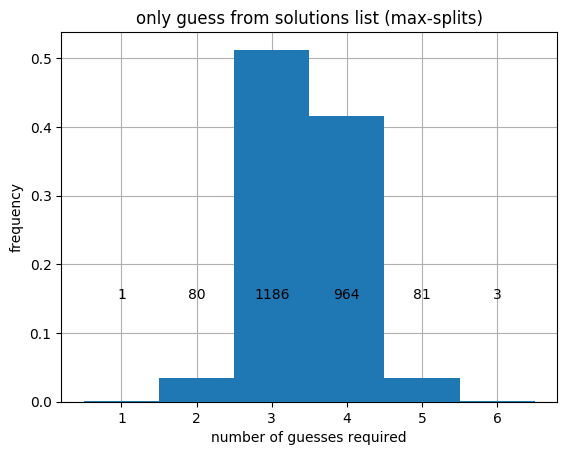

Guess: trace

Proportions
6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0345572
3     │    0.512311
4     │    0.416415
5     │   0.0349892
6     │   0.0012959

Mean Score
3.4548596112311016
  2.096255 seconds (49.31 M allocations: 2.272 GiB, 16.73% gc time)


In [6]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = false,
    heuristic = PRIORITIZE_SPLITS
)

### Using all possible words as guesses, prioritizing entropy

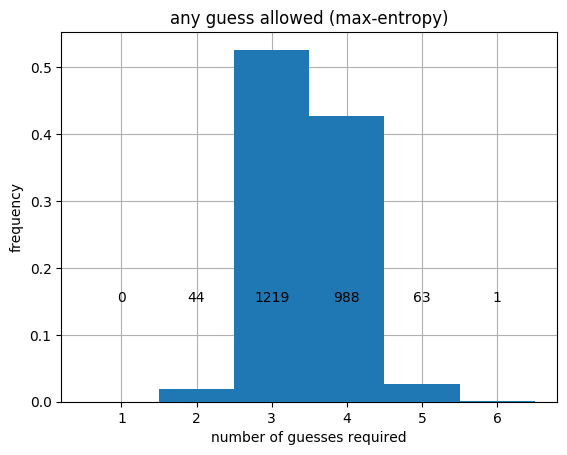

Guess: soare

Proportions
5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
2     │   0.0190065
3     │    0.526566
4     │    0.426782
5     │   0.0272138
6     │ 0.000431965

Mean Score
3.4634989200863933
 12.726652 seconds (290.44 M allocations: 12.845 GiB, 21.87% gc time)


In [7]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = false,
    heuristic = PRIORITIZE_ENTROPY
)

### Using all possible words as guesses, prioritizing maxsize

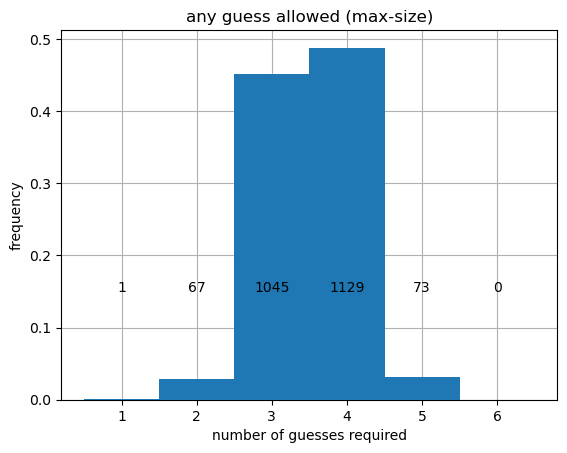

Guess: raise

Proportions
5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0289417
3     │    0.451404
4     │    0.487689
5     │   0.0315335

Mean Score
3.5209503239740823
 16.669453 seconds (305.46 M allocations: 13.663 GiB, 10.68% gc time, 12.18% compilation time)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\laure\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [4]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = false,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE,
    max_val = 6
)

### Using all possible words as guesses, prioritizing max splits

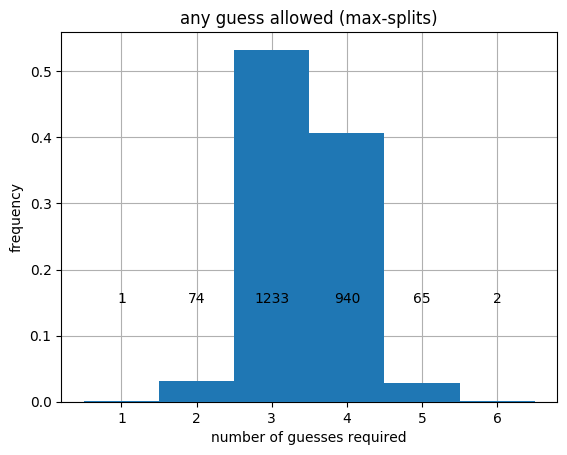

Guess: trace

Proportions
6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0319654
3     │    0.532613
4     │    0.406048
5     │   0.0280778
6     │ 0.000863931

Mean Score
3.4319654427645787
 13.649576 seconds (284.48 M allocations: 12.602 GiB, 19.26% gc time)


In [9]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = false,
    heuristic = PRIORITIZE_SPLITS
)

### Using only solutions words as guesses + hard mode, prioritizing entropy

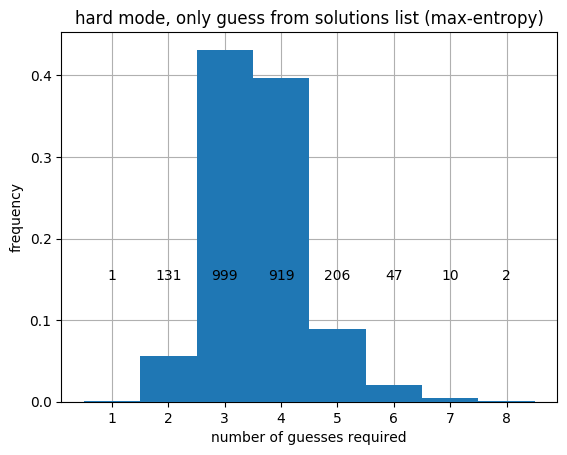

Guess: raise

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0565875
3     │    0.431533
4     │    0.396976
5     │   0.0889849
6     │   0.0203024
7     │  0.00431965
8     │ 0.000863931

Mean Score
3.6
  0.721388 seconds (15.45 M allocations: 551.291 MiB, 10.02% gc time)


In [10]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = true,
    heuristic = PRIORITIZE_ENTROPY
)

### Using only solutions words as guesses + hard mode, prioritizing maxsize

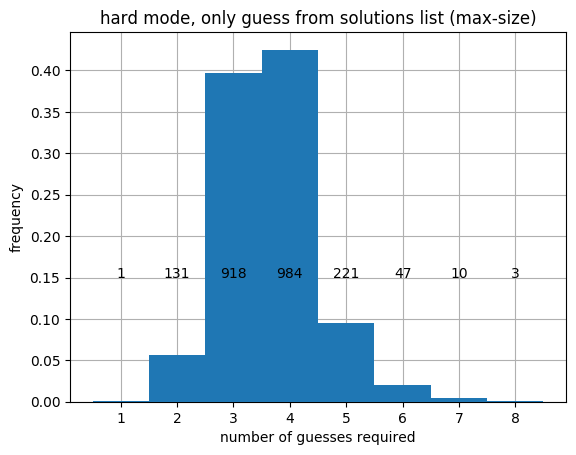

Guess: raise

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0565875
3     │    0.396544
4     │    0.425054
5     │   0.0954644
6     │   0.0203024
7     │  0.00431965
8     │   0.0012959

Mean Score
3.643196544276458
  0.738441 seconds (15.43 M allocations: 551.190 MiB, 10.52% gc time)


In [11]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = true,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE
)

### Using only solutions words as guesses + hard mode, prioritizing max splits

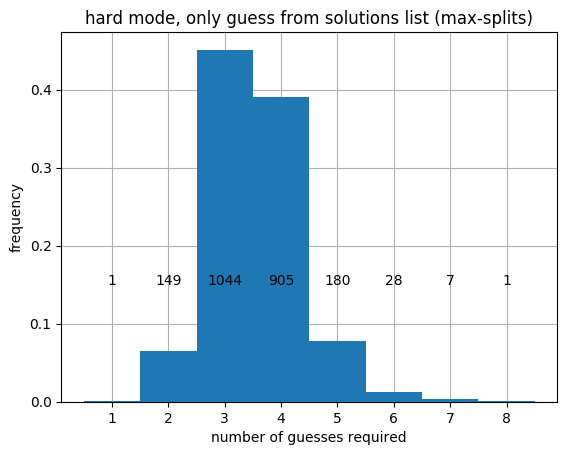

Guess: trace

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0643629
3     │    0.450972
4     │    0.390929
5     │   0.0777538
6     │    0.012095
7     │  0.00302376
8     │ 0.000431965

Mean Score
3.5317494600431965
  0.813628 seconds (15.30 M allocations: 551.385 MiB, 19.41% gc time)


In [12]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = true,
    heuristic = PRIORITIZE_SPLITS
)

### Using all possible words as guesses + hard mode, prioritizing entropy

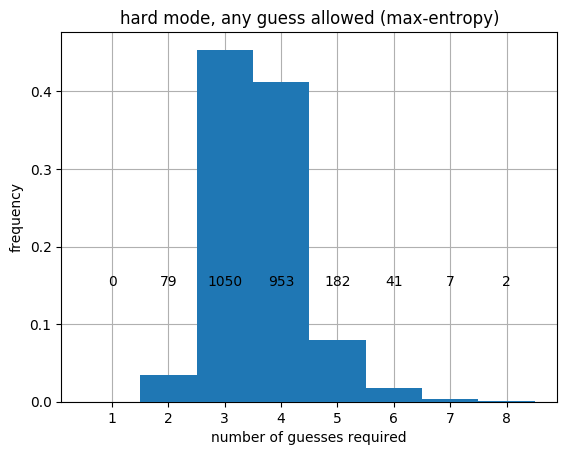

Guess: soare

Proportions
7-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
2     │   0.0341253
3     │    0.453564
4     │    0.411663
5     │   0.0790497
6     │   0.0177106
7     │  0.00302376
8     │ 0.000863931

Mean Score
3.605183585313175
  4.246831 seconds (91.46 M allocations: 3.064 GiB, 22.46% gc time)


In [13]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = true,
    heuristic = PRIORITIZE_ENTROPY
)

### Using all possible words as guesses + hard mode, prioritizing maxsize

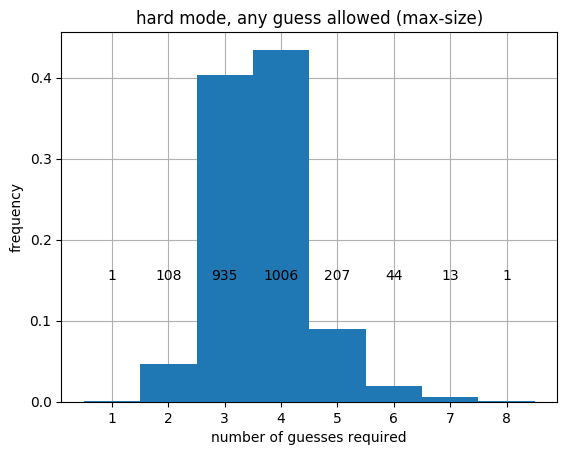

Guess: raise

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0466523
3     │    0.403888
4     │    0.434557
5     │   0.0894168
6     │   0.0190065
7     │  0.00561555
8     │ 0.000431965

Mean Score
3.647516198704104
  4.472704 seconds (91.64 M allocations: 3.070 GiB, 25.08% gc time)


In [14]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = true,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE
)

### Using all possible words as guesses + hard mode, prioritizing max splits

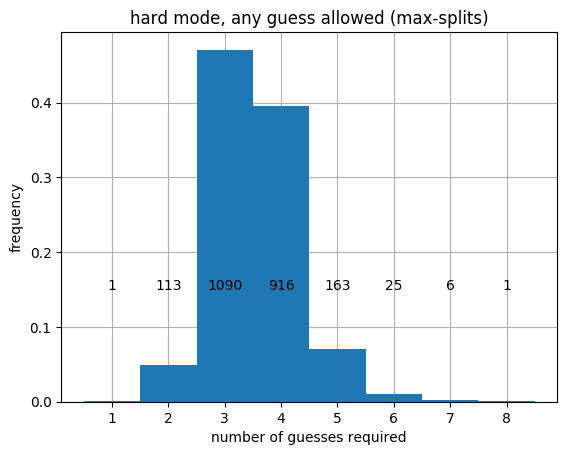

Guess: trace

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0488121
3     │    0.470842
4     │     0.39568
5     │   0.0704104
6     │   0.0107991
7     │  0.00259179
8     │ 0.000431965

Mean Score
3.5317494600431965
  4.421094 seconds (91.97 M allocations: 3.107 GiB, 18.68% gc time)


In [15]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = true,
    heuristic = PRIORITIZE_SPLITS
)